```{index} single: application; regression
```
```{index} scatterplot
```

# Ordinary Least Squares (OLS) Regression

In Chapter 2 we introduced linear regression with least absolute deviations (LAD), see [this notebook](../02/lad-regression.ipynb). Here we consider the same problem setting, but slightly change the underlying optimization problem, in particular its objective function, obtaining the classical ordinary least squares (OLS) regression.

In [1]:
# install AMPL and solvers
%pip install -q amplpy

SOLVER_LO = "cbc"
SOLVER_QO = "ipopt"

from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["coin"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 13.8 MB/s eta 0:00:00
Using default Community Edition License for Colab. Get yours at: https://ampl.com/ce
Licensed to AMPL Community Edition License for the AMPL Model Colaboratory (https://colab.ampl.com).


## Generate data

The Python [scikit learn](https://scikit-learn.org/stable/) library for machine learning provides a full-featured collection of tools for regression. The following cell uses `make_regression` from scikit learn to generate a synthetic data set for use in subsequent cells. The data consists of a numpy array `y` containing `n_samples` of one dependent variable $y$, and an array `X` containing `n_samples` observations of `n_features` independent explanatory variables.

In [2]:
from sklearn.datasets import make_regression
import numpy as np
import matplotlib.pyplot as plt

n_features = 1
n_samples = 500
noise = 75

# generate regression dataset
np.random.seed(2022)
X, y = make_regression(n_samples=n_samples, n_features=n_features, noise=noise)

## Data Visualization

Before going further, it is generally useful to prepare an initial visualization of the data. The following cell presents a scatter plot of $y$ versus $x$ for the special case of one explanatory variable, and a histogram of the difference between $y$ and the mean value $\bar{y}$. This histogram will provide a reference against which to compare the residual error in $y$ after regression.

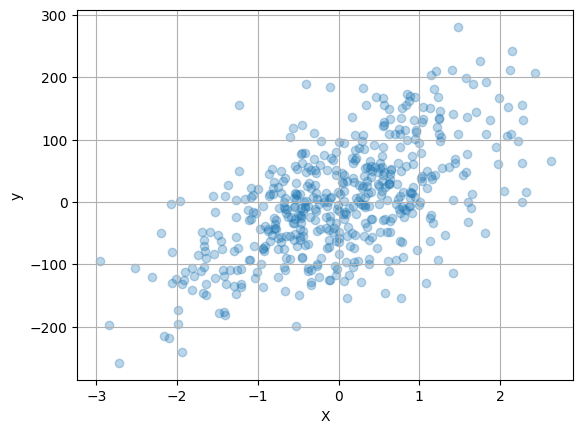

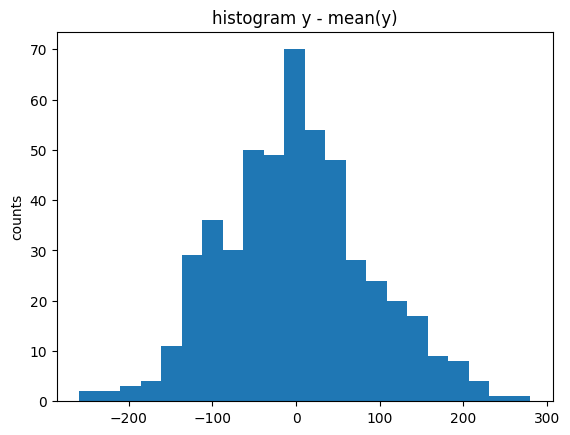

In [3]:
if n_features == 1:
    plt.scatter(X, y, alpha=0.3)
    plt.xlabel("X")
    plt.ylabel("y")
    plt.grid(True)

plt.figure()
plt.hist(y - np.mean(y), bins=int(np.sqrt(len(y))))
plt.title("histogram y - mean(y)")
plt.ylabel("counts")
plt.show()

## Model

Similarly to the LAD regression example, suppose we have a finite data set consisting of $n$ points $\{({X}^{(i)}, y^{(i)})\}_{i=1,\dots,n}$ with ${X}^{(i)} \in \mathbb R^k$ and $y^{(i)} \in \mathbb R$. We want to fit a linear model with intercept, whose error or deviation term $e_i$ is equal to

$$
    e_i = y^{(i)} - {m}^\top {X}^{(i)} - b = y^{(i)} - \sum_{j=1}^k X^{(i)}_j m_j - b,
$$

for some real numbers $b, m_1,\dots,m_k$. The Ordinary Least Squares (OLS) is a possible statistical optimality criterion for such a linear regression, which tries to minimize the sum of the errors squares, that is $\sum_{i=1}^n e_i^2$. The OLS regression can thus be formulated as an optimization with the coefficients $b$ and $m_i$'s and the errors $e_i$'s as the decision variables, namely

$$
\begin{align}
    \min \quad & \sum_{i=1}^n e_i^2\\
    \text{s.t.} \quad & e_i = y^{(i)} - {m}^\top {X}^{(i)} - b, \qquad \forall\, i=1,\dots,n.
\end{align}
$$

In [4]:
def ols_regression(X, y):
    m = AMPL()
    m.eval(
        """
      reset;

      set I;
      set J;
      
      var e{I};
      var m{J};
      var b;

      param X{I, J};
      param y{I};

      subject to residuals{i in I}:
        e[i] = y[i] - sum{j in J} X[i,j]*m[j] - b;

      minimize sum_of_square_errors:
        sum{i in I} e[i]**2;
    """
    )

    n, k = X.shape

    m.set["I"] = list(range(n))
    m.set["J"] = list(range(k))

    m.param["X"] = X
    m.param["y"] = y

    m.option["solver"] = SOLVER_QO
    m.get_output("solve;")
    return m


m = ols_regression(X, y)
m_ols = [m.var["m"][j].value() for j in m.set["J"].members()]
b_ols = m.var["b"].value()
print("OLS Regression\n")
print("m:", *m_ols)
print("b:", b_ols)
print("Sum of error squares:", m.obj["sum_of_square_errors"].value())

OLS Regression

m: 53.49847313217242
b: 0.4280946804476905
Sum of error squares: 2466403.832701945


## Convexity

Denote by ${\theta}=(b,{m}) \in \mathbb{R}^{k+1}$ the vector comprising all variables, by $y =(y^{(1)}, \dots, y^{(n)})$, and by ${\tilde{X}} = \mathbb{R}^{d \times (n+1)}$ the so-called *design matrix* associated with the dataset, that is

$$
    {\tilde{X}} = \left[
    \begin{array}{cccc}
    {1} & {X}^{(1)} & \dots & {X}^{(n)}
    \end{array}\right].
$$

We can then rewrite the minimization problem above as an unconstrained optimization problem in the vector of variables ${\theta}$, namely

$$
    \min_{{\theta}} f({\theta}),
$$

with $f: \mathbb{R}^{k+1} \rightarrow \mathbb{R}$ defined as $f({\theta}):=\| {y} - {\tilde{X}} {\theta} \|_2^2$. Note that here $y$ and ${X}^{(i)}$, $i=1,\dots,n$ are not a vector of variables, but rather of known parameters. The Hessian of the objective function can be calculated to be

$$
    \nabla^2 f(\theta) = 2 {\tilde{X}}^\top {\tilde{X}}.
$$

In particular, it is a constant matrix that does not depend on the variables ${\theta}$ and it is always positive semi-definite, since

$$
    t^\top \nabla^2 f(\theta) t = 2 t^\top {\tilde{X}}^\top \tilde{X} t = 2 \| {\tilde{X}} t \|_2^2 \geq 0, \qquad \forall \, t \in \mathbb{R}^{k+1}.
$$

The OLS optimization problem is then always convex.

## Visualizing the results and comparison with LAD regression

In [5]:
def lad_regression(X, y):
    m = AMPL()
    m.eval(
        """
      reset;

      set I;
      set J;
      
      var ep{I} >= 0;
      var em{I} >= 0;
      var m{J};
      var b;

      param X{I, J};
      param y{I};

      subject to residuals{i in I}:
        ep[i] - em[i] = y[i] - sum{j in J} X[i,j]*m[j] - b;

      minimize sum_of_abs_errors:
        sum{i in I} (ep[i] + em[i]);
    """
    )

    n, k = X.shape

    m.set["I"] = list(range(n))
    m.set["J"] = list(range(k))

    m.param["X"] = X
    m.param["y"] = y

    m.option["solver"] = SOLVER_LO
    m.get_output("solve;")
    return m


m = lad_regression(X, y)
m_lad = [m.var["m"][j].value() for j in m.set["J"].members()]
b_lad = m.var["b"].value()
print("\nLAD Regression\n")
print("m:", *m_lad)
print("b:", b_lad)
print("Sum of abs squares:", m.obj["sum_of_abs_errors"].value())


LAD Regression

m: 51.42857640061373
b: -1.413026812508927
Sum of abs squares: 27907.63319057619


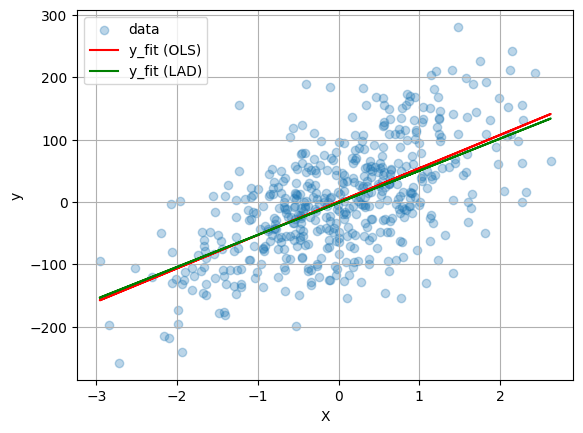

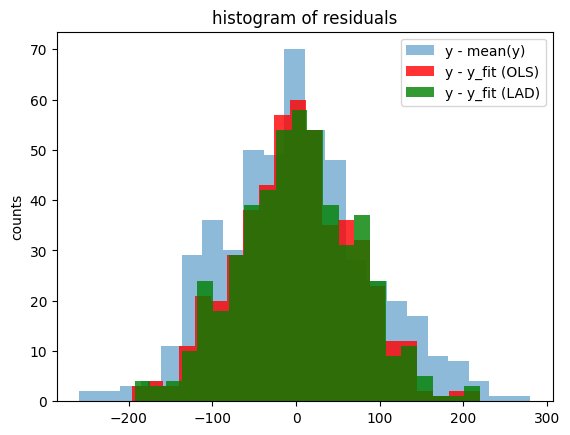

In [6]:
y_fit = np.array([sum(x[j] * m_ols[j] for j in range(X.shape[1])) + b_ols for x in X])
y_fit2 = np.array([sum(x[j] * m_lad[j] for j in range(X.shape[1])) + b_lad for x in X])

if n_features == 1:
    plt.scatter(X, y, alpha=0.3, label="data")
    plt.plot(X, y_fit, "r", label="y_fit (OLS)")
    plt.plot(X, y_fit2, "g", label="y_fit (LAD)")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.grid(True)
    plt.legend()

plt.figure()
plt.hist(y - np.mean(y), bins=int(np.sqrt(len(y))), alpha=0.5, label="y - mean(y)")
plt.hist(
    y - y_fit,
    bins=int(np.sqrt(len(y))),
    color="r",
    alpha=0.8,
    label="y - y_fit (OLS)",
)
plt.hist(
    y - y_fit2,
    bins=int(np.sqrt(len(y))),
    color="g",
    alpha=0.8,
    label="y - y_fit (LAD)",
)
plt.title("histogram of residuals")
plt.ylabel("counts")
plt.legend()
plt.show()